<a href="https://colab.research.google.com/github/djakesa/AE-VAE-GAN-CelebA/blob/main/jacques_autoencoder_celebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import shutil

# Démontage s'il est déjà monté
try:
    !fusermount -u /content/drive
except:
    pass

# Suppression du dossier de montage s'il reste
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive', ignore_errors=True)

# Montage propre
drive.mount('/content/drive', force_remount=True)


fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


On va importer la BDD celebA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Chemin du fichier ZIP et dossier de destination
zip_path = '/content/drive/MyDrive/CelebA/Img/img_align_celeba.zip'
extract_to = '/content/drive/MyDrive/img_align_celeba'

# Vérification du nombre d'images déjà extraites
existing_images = [
    f for f in os.listdir(extract_to)
    if f.lower().endswith('.jpg')
] if os.path.exists(extract_to) else []

nb_existing = len(existing_images)
print(f"{nb_existing} image(s) déjà présentes dans {extract_to}")

# Extraction uniquement si moins de 5000 images
if nb_existing < 5000:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        jpg_files = sorted([f for f in zip_ref.namelist() if f.lower().endswith('.jpg')])
        images_to_extract = jpg_files[nb_existing:5000]

        os.makedirs(extract_to, exist_ok=True)

        for file in images_to_extract:
            zip_ref.extract(file, extract_to)

        print(f"{len(images_to_extract)} image(s) ajoutée(s).")

else:
    print("Pas besoin d'extraction, 5000 images ou plus déjà présentes.")

# Affichage final du total
total_images = len([
    f for f in os.listdir(extract_to)
    if f.lower().endswith('.jpg')
])
print(f"Nombre total d'images maintenant dans {extract_to} : {total_images}")



(218, 178, 3)


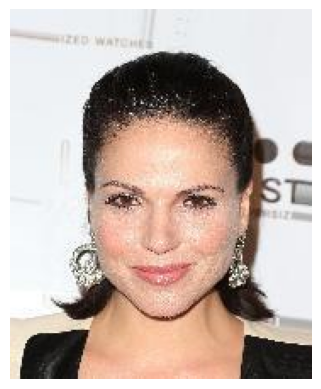

In [ ]:
import cv2
import matplotlib.pyplot as plt


img_path = '/content/drive/MyDrive/img_align_celeba/img_align_celeba/005000.jpg'

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print (img_rgb.shape)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

On construit une classe pour l'autoencodeur

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
#from utils.callbacks import CustomCallback, step_decay_schedule
import numpy as np
import json
import os
import pickle
from keras.callbacks import Callback, LearningRateScheduler

class CustomCallback(Callback): # Callback classe mère
    # initialise les attributs de la classe CustomCallback
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, model):
        super().__init__() # appelle le constructeur de la classe mère
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.initial_epoch = initial_epoch
        self.ae_model = model.model  # évite le conflit avec la propriété `self.model`

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            print(f"[Epoch {epoch + 1}] — Loss: {loss:.4f}")
        else:
            print(f"[Epoch {epoch + 1}] — Loss not available.")


# fait décroître le learning rate pendant l'entraînement ( meilleure convergence + évite de rester dans un minimum local )

def step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return LearningRateScheduler(schedule, verbose=1) #renvoi un callback Keras pour model.fit()



class Autoencodeur():
    # on définit les attributs de la classe Autoencodeur
    def __init__(self
    , input_dim
    ,encoder_conv_filters
    ,encoder_conv_kernels
    ,encoder_conv_strides
    ,decoder_conv_t_filters
    ,decoder_conv_t_kernels
    ,decoder_conv_t_strides
    ,z_dim
    ,use_batch_norm = "False"
    ,use_dropout = "False"
    ):
        self.name = "Autoencoder"
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernels = encoder_conv_kernels
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernels = decoder_conv_t_kernels
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    # On build notre autoencoder

    def _build(self):
        encoder_input = Input(shape = self.input_dim , name = 'encoder_input')

        x= encoder_input

        for i in range(self.n_layers_encoder) :
            conv_layer = Conv2D (filters = self.encoder_conv_filters[i]
                                 ,kernel_size = self.encoder_conv_kernels[i]
                                 ,strides = self.encoder_conv_strides[i]
                                 ,padding='same'
                                 ,name = 'encoder_conv_' + str(i)
                                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        encoder_output= Dense(self.z_dim, name='encoder_output')(x)

        self.encoder = Model(encoder_input, encoder_output)

        # On construit le decodeur
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernels[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                x = LeakyReLU()(x)

                if self.use_batch_norm:
                    x = BatchNormalization()(x)

                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL AUTOENCODER
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)

    def compile(self, learning_rate):
        self.learning_rate = learning_rate

        optimizer = Adam(learning_rate=learning_rate)

        def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

        self.model.compile(optimizer=optimizer, loss = r_loss)

    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernels
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernels
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)




    def load_weights(self, filepath):
        self.model.load_weights(filepath)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint2, custom_callback, lr_sched]

        self.model.fit(
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)



On détermine les paramètres de la classe que l'on souhaite

In [ ]:
import os
#import keras # Remove or comment out the old import if present
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
#from utils.callbacks import CustomCallback, step_decay_schedule
import numpy as np
import json
import os
import pickle
import tensorflow as tf

from tensorflow.keras.callbacks import Callback, LearningRateScheduler

# run params
SECTION = 'ae'
RUN_ID = '0001'
DATA_NAME = 'celebA'
RUN_FOLDER = os.path.join('run', SECTION, '_'.join([RUN_ID, DATA_NAME]))

# Création des dossiers nécessaires
if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)  # Création du dossier principal
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))

MODE = 'load'  #  'load' ou 'build'

# Chargement de 1000 images CelebA depuis le dossier extrait
import cv2
import numpy as np
import os

image_dir = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'
image_paths = sorted([
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.endswith('.jpg')
])[:1000]  # pour un entraînement rapide

def load_images(paths):
    images = []
    for path in paths:
        img = cv2.imread(path)
        # Check if image was loaded correctly
        if img is None:
            print(f"Error loading image: {path}")
            continue  # Skip this image and proceed with the next
        img = cv2.resize(img, (128, 128))  # <<< réduction de taille ici
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

x_train = load_images(image_paths)

# Ensure using GPU

with tf.device('/GPU:0'): # Specify the GPU device
  # Construction du modèle
  autoencodeur = Autoencodeur(
      input_dim=(128, 128, 3),
      encoder_conv_filters=[32, 64, 64, 64],
      encoder_conv_kernels=[3, 3, 3, 3],
      encoder_conv_strides=[1, 2, 2, 1],
      decoder_conv_t_filters=[64, 64, 32, 3],
      decoder_conv_t_kernels=[3, 3, 3, 3],
      decoder_conv_t_strides=[1, 2,2, 1],
      z_dim=200,
      use_batch_norm=False,
      use_dropout=False
  )

# Enregistrement ou chargement
  if MODE == 'build':
      autoencodeur.compile(learning_rate=0.0005) # learning_rate is set here
      autoencodeur.save(RUN_FOLDER)

      # Entraînement
      autoencodeur.train(
          x_train=x_train,
          batch_size=32,
          epochs=20,
          run_folder=RUN_FOLDER,
          initial_epoch=0
  )
  else:
      autoencodeur.load_weights(os.path.join(RUN_FOLDER, 'weights', 'weights.weights.h5'))

  # Résumé du modèle
  autoencodeur.encoder.summary()

Error loading image: /content/drive/MyDrive/img_align_celeba/img_align_celeba/000165.jpg


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_0 (Conv2D)         │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_1 (Conv2D)         │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_2 (Conv2D)         │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_3 (Conv2D)         │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 200)            │    13,107,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,200,648 (50.36 MB)

 Trainable params: 13,200,648 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


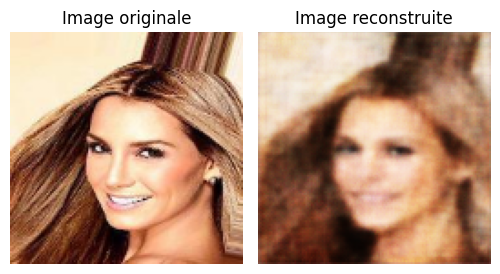

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


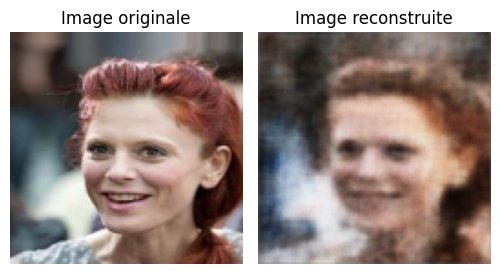

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


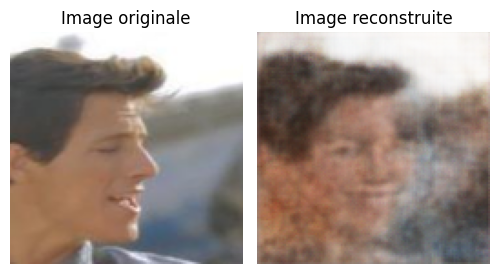

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


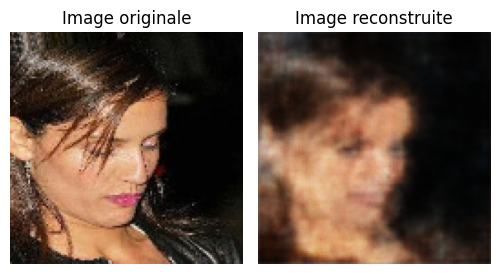

In [ ]:
import matplotlib.pyplot as plt

for i in range (0,4) :
  # Images de test
  test_img = x_train[i]  # Ou une autre image déjà normalisée et 128x128

  # Préparer pour le modèle
  test_img_input = np.expand_dims(test_img, axis=0)  # Le modèle attend un batch passe en dim (1,128,128,3)

  reconstructed_img = autoencodeur.model.predict(test_img_input)[0]  # Recupère la seule image du batch

  plt.figure(figsize=(15, 8))

  # Image originale
  plt.subplot(2, 6, i+1)
  plt.imshow(test_img[..., ::-1])  # BGR → RGB
  plt.title('Image originale')
  plt.axis('off')

  # Image reconstruite
  plt.subplot(2, 6, i+2)
  plt.imshow(reconstructed_img[..., ::-1])  # BGR → RGB
  plt.title('Image reconstruite')
  plt.axis('off')

  plt.tight_layout()
  plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


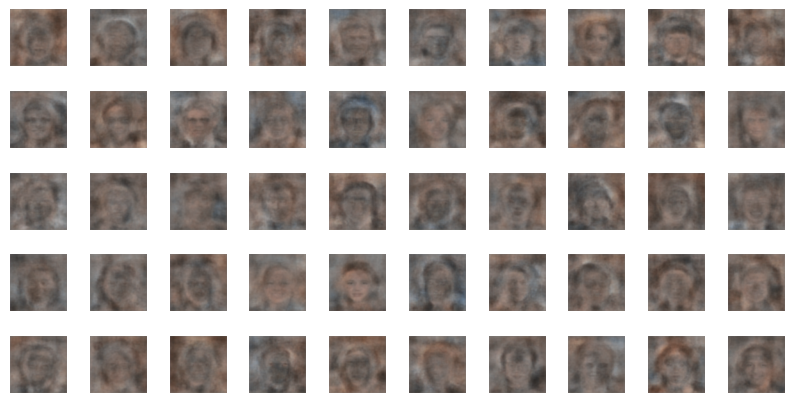

In [ ]:
# 1. Création de points aléatoires dans z_dim=200
grid_size = 10
grid_depth = 5
z_random = np.random.normal(0, 1, size=(grid_size * grid_depth, autoencodeur.z_dim))

# 2. Décodage → images RGB reconstruites
reconstructed_images = autoencodeur.decoder.predict(z_random)

# 3. Affichage des images
fig = plt.figure(figsize=(grid_size, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    # Display a single image from the batch
    ax.imshow(reconstructed_images[i, ..., ::-1])  # pas de cmap ici : c’est du RGB
plt.show()